# Horizon

The notebook will investigate the `viewf.horizon.horizon` function and compare with the IPW version.

In [1]:
import numpy as np
from spatialnc import ipw
import matplotlib.pyplot as plt

from viewf.horizon import horizon
from viewf.skew import skew

In [2]:
class TestHorizon():
    
    int_min = 0
    int_max = 2**16-1   # 16 bit images

    def __init__(self, azimuth):

        self.azimuth = azimuth
        
        # input DEM
        infile = '../tests/Lakes/gold/gold_dem.ipw'
        d = ipw.IPW(infile)

        # C code for hor1d is expecting double
        # the LQ headers have added some small values in the linearization of the image
        self.gold_dem = np.double(d.bands[0].data)
        self.spacing = d.bands[0].dline
        
#         # go through the LQ headers for the DEM
#         self.float_max = self.gold_dem.max()
#         self.float_min = self.gold_dem.min()
#         self.gold_dem_int = ipw.map_fn(self.gold_dem, self.float_min,
#                            self.float_max, self.int_min, self.int_max)
#         self.gold_dem_float = self.int_to_float(self.gold_dem_int)

        # Horizon gold files
        self.gold_file = '../tests/Lakes/gold/horizon/horizon_{}.ipw'.format(azimuth)
        gold = ipw.IPW(self.gold_file)
        self.gold_data = gold.bands[0].data

        # to make a fair comparison, first convert the hcos to
        # integers then back using the 16 bit LQ
        # with horizon the float min/max are constant from 0-1
        self.float_min = 1.0
        self.float_max = 0.0   
        
        self.run_horizon()
        
        # Read in the integer data from the IPW file in order to see
        # if the LQ transform is adding some rounding errors
        fid = open(self.gold_file, 'rb')
        while True:  # while 1 is faster than while True
            line = fid.readline().decode('utf-8')
            if '\f' in line:  # feed form character separates the
                    break         # image header from the binary data
            
        # Unpack the binary data using numpy.fromfile
        # because we have been reading line by line fid is at the
        # first data byte, we will read it all as one big chunk
        # and then put it into the appropriate bands
        #
        # np.types allow you to define heterogenous arrays of mixed
        # types and reference them with keys, this helps us out here
        dt = 'uint16'

        # this is way faster than looping with struct.unpack
        # struct.unpack also starts assuming there are pad bytes
        # when format strings with different types are supplied
        count = d.bands[0].nlines * d.bands[0].nsamps
        data = np.fromfile(fid, dt, count=count)

        # Separate into bands
        self.int_data = data.reshape(d.bands[0].nlines, d.bands[0].nsamps)


    def int_to_float(self, x):
        return (self.float_max - self.float_min) * \
            (x / self.int_max) + self.float_min

    def run_horizon(self):
        """Run the horizon function for a given azimuth and
        compare with the gold file

        Arguments:
            azimuth {float} -- azimuth to test
        """

        self.hcos = horizon(self.azimuth, self.gold_dem, self.spacing)

        # convert the numpy array from a float, to int and back
        self.h_int = ipw.map_fn(self.hcos, self.float_min,
                           self.float_max, self.int_min, self.int_max)
        self.h_float = self.int_to_float(self.h_int)
        
    def plot(self):
        d = self.gold_data - self.h_float
#         d = self.int_data - self.h_int

        fig, ax = plt.subplots(2, 2, figsize = (15, 15))
        fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
        fig.suptitle('{} degrees'.format(self.azimuth))

        # IPW original
        im0 = ax[0, 0].imshow(self.gold_data)
        ax[0, 0].set_title('IPW output')
        fig.colorbar(im0, ax=ax[0, 0])

        # horizon output
        im1 = ax[0, 1].imshow(self.h_float)
        ax[0, 1].set_title('horizon output')
        fig.colorbar(im1, ax=ax[0, 1])

        # difference
        var_lim = max([abs(d.min()), abs(d.max())])
        im2 = ax[1, 0].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
        ax[1, 0].set_title('Difference, gold - new')
        fig.colorbar(im2, ax=ax[1, 0])

        ax[1, 1].hist(d, bins=30)
        ax[1, 1].set_title('Histogram')

        # remove the x and y ticks
        for a in ax.flatten()[:3]:
            a.set_xticks([])
            a.set_yticks([])

        plt.show()

        

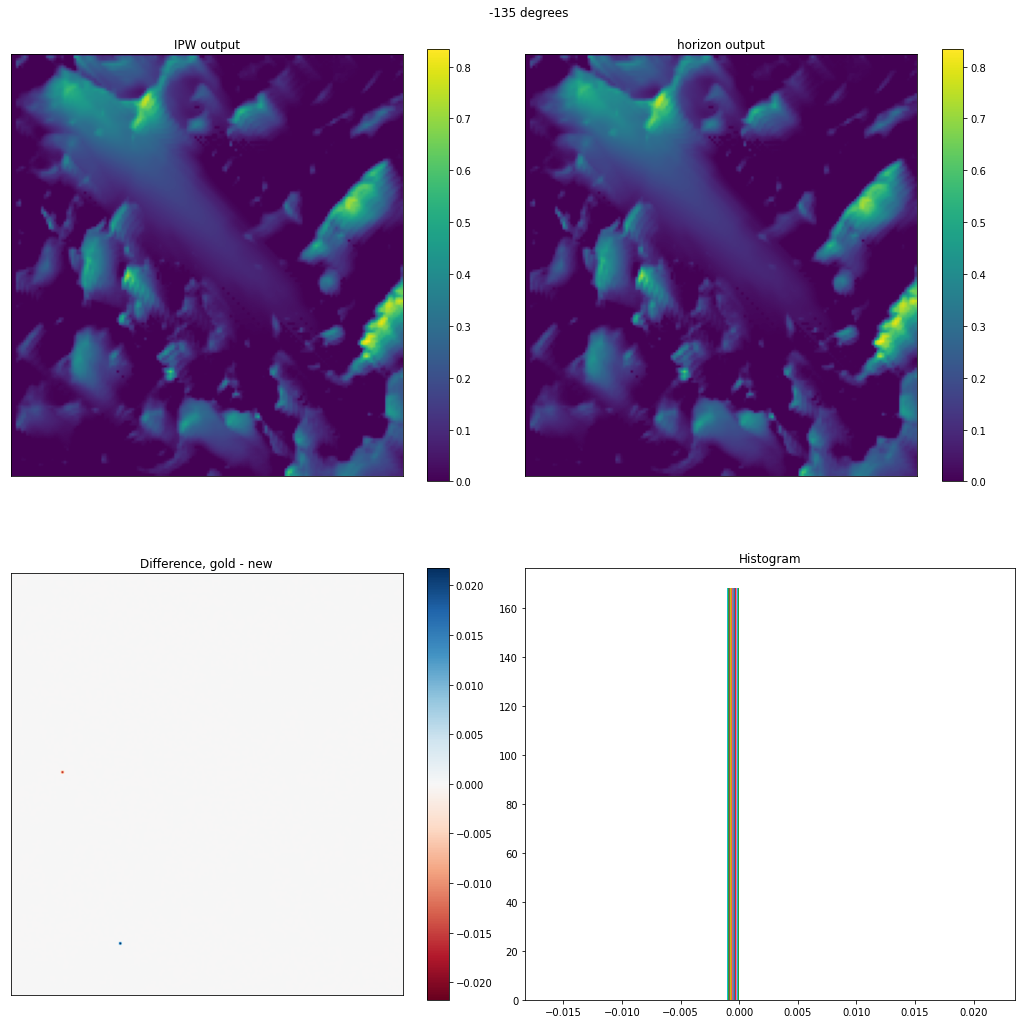

In [4]:
# East or 90 degrees
h = TestHorizon(-135)
# np.testing.assert_allclose(h.h_float, h.gold_data, rtol=1e-07, atol=1e-4)
h.plot()

In [ ]:
# West or -90 degrees
h = TestHorizon(-90)
np.testing.assert_allclose(h.h_float, h.gold_data, rtol=1e-07, atol=1e-4)
h.plot()

0


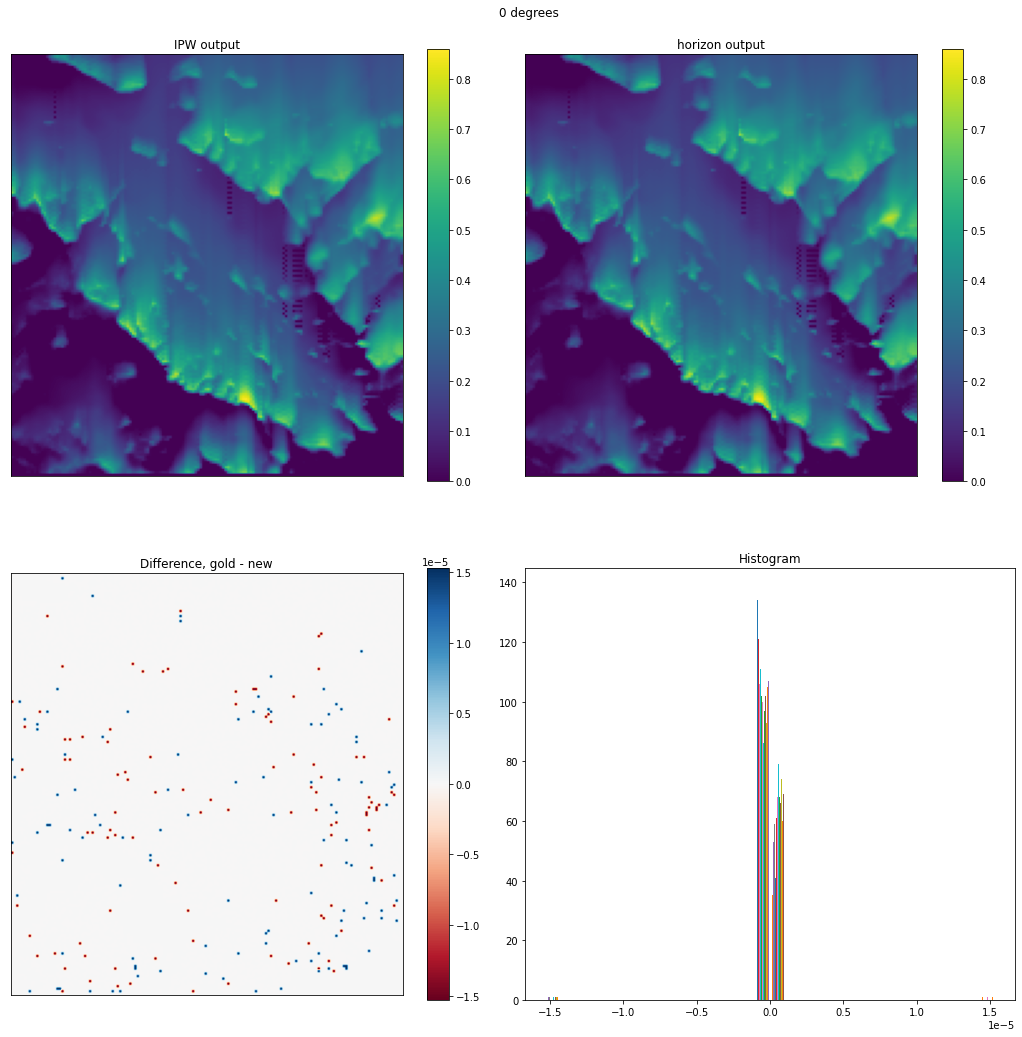

In [4]:
# South or 0 degrees
h = TestHorizon(0)
np.testing.assert_allclose(h.h_float, h.gold_data, rtol=1e-07, atol=1e-4)
h.plot()

In [ ]:
# North or 0 degrees
h = TestHorizon(180)
np.testing.assert_allclose(h.h_float, h.gold_data, rtol=1e-07, atol=1e-4)
h.plot()

[[3147.836  3162.8906 3179.4067 ... 2383.8496 2383.8496 2383.8496]
 [2383.8496 3134.6265 3148.0552 ... 2383.8496 2383.8496 2383.8496]
 [2383.8496 2383.8496 3114.8948 ... 2383.8496 2383.8496 2383.8496]
 ...
 [2383.8496 2383.8496 2383.8496 ... 3286.872  2383.8496 2383.8496]
 [2383.8496 2383.8496 2383.8496 ... 3265.3132 3282.3594 2383.8496]
 [2383.8496 2383.8496 2383.8496 ... 3249.7288 3264.6006 3280.0754]]


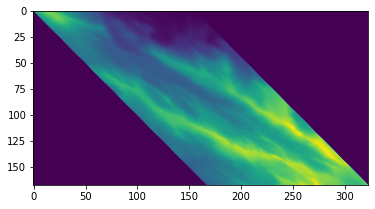

In [6]:
i = ipw.IPW('../tests/Lakes/gold/skew/skew_-45.ipw')
plt.imshow(i.bands[0].data)
print(i.bands[0].data)